# Homework 2

**Name**: Rogerio Lima

### Due Date: Friday, March 20

### Policy Gradient

In this assignment, we will implement vanilla policy gradient algorithm (REINFORCE) covered in the lecture. You will work on i) a function approximator, ii) computing action, iii) collecting samples, iV) training the agent, V) plotting the resutls. 


***Complete the missing operations and test your implemented algorithm on the Gym environment.***

***Software requirements:***
- Python >= 3.6
- Tensorflow version <= 1.15.3 (1.X version)
- OpenAI Gym

- Training the agent (policy) can take long time. It is recomended to start solving the problems earlier.

- Save any plots you generated in this notebook. The grade will be given based on the plots you showed.



Make sure the packages you installed meet the requirements.

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
import gym
gym.__version__

'0.18.0'

## 1.1 Tensorflow Implementation

We will be implementing policy gradient algorithm using Tensorflow 1.X., which simply updates the parameters of policy from obtaining gradient estimates. The core of policy gradient is to design a function approximator, computing actions, collecting samples, and training the policy. In the below cell, you are encouraged to fill in the components that are missing. ***Your tasks*** are 

1. Complete the 'create_model' method to output the mean value for diagonal Guassian policy. Covariance is already defined in the model, so focus on creating neural network model.

2. Complete the 'action_op' method to calculate and return the actions for diagonal Gaussian policy. The applied action should be $\pi(s) = \pi_{\text{mean}}(s) + exp(logstd) * \mathcal{N}(0,1)$

***Hints***:
- Some useful tensorflow classes and methods include: 'tf.exp', 'tf.random_normal'



In [3]:
import tensorflow as tf
import numpy as np
import os
import ipdb
 
 
class PolicyOpt(object):
 
    def __init__(self, env, linear=False, stochastic=True, hidden_size=32, nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.
 
        This initializes the policy optimization with a set of trainable 
        parameters, and creates a tensorflow session.
 
        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. Fully-Connected-Neural-Network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to True
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        
        # clear computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env
        
        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]
 
        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])
 
        # specifies whether the policy is stochastic
        self.stochastic = stochastic
 
        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )
        
        # define symbolic action
        self.symbolic_action = self.action_op()
 
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())
 
        # create saver to save model variables
        self.saver = tf.train.Saver()
 
    def create_model(self, args):
        """Create a model for your policy or other components.
 
        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": True by default
              - "hidden_size": Number of neurons in hidden layer
              - "num_actions" number of output actions
              - "scope": scope of the model
 
        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable 
            logstd of the policy actions
        """
 
        #################### Build Your Neural Network Here! ####################
        # Rule of thumb:
        #  a) # of hidden layers = 1
        #  b) size (# neurons) of hidden layer ~ btw the input and output layers
        # ----------------------------------------------------------------------
        # Ref.: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
        #       https://openreview.net/forum?id=jh-rTtvkGeM
        #       https://openreview.net/pdf?id=jh-rTtvkGeM

        num_neurons = int(np.ceil(0.5*args["hidden_size"]))


        input_layer  = tf.layers.dense(self.s_t_ph, 
                                        args["hidden_size"], 
                                        activation=args["nonlinearity"])
        hidden_layer = tf.layers.dense(input_layer, num_neurons, 
                                        activation=tf.nn.relu)
        output_mean  = tf.layers.dense(hidden_layer, args["num_actions"]) 
        ##########################################################################        
 
        if args["stochastic"]:
            output_logstd =  tf.get_variable(name="action_logstd",shape=[self.ac_dim],trainable=True)
        else:
            output_logstd = None
 
        return output_mean, output_logstd
    
    def action_op(self):
        """
        Create a symbolic expression that will be used to compute actions from observations.
 
        When the policy is stochastic, the action follows 
 
            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy
 
            #################### Implement a stochastic policy here ####################        
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # The action in a stochastic policy represented by           #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "logstd" is computed as follows:        #
            #                                                            #
            #     a = M + exp(logstd) * z                                #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #
            ############################################################################ 
            M = output_mean
            exp_logstd = tf.math.exp(output_logstd)
            z = tf.random_normal([1])
 
            symbolic_action = M + exp_logstd*z;     
            
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action
 
    def compute_action(self, obs):
        """Returns a list of actions for a given observation.
 
        Parameters
        ----------
        obs : np.ndarray
            observations
 
        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action,feed_dict={self.s_t_ph: obs})
 
    def rollout(self, s_mean=None, s_std=None):
        """Collect samples from one rollout of the policy.
 
        Returns
        -------
        dict
            dictionary containing trajectory information for the rollout,
            specifically containing keys for "state", "action", "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []
 
        # start a new rollout by re-setting the environment and collecting the initial state
        state =  self.env.reset()
 
        steps = 0
        while True:
            steps += 1
 
            # compute the action given the state
            if s_mean is not None and s_std is not None:
                action = self.compute_action([(state - s_mean) / s_std])
            else:
                action = self.compute_action([state])
            action = action[0]
 
            # advance the environment once and collect the next state, reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)
 
            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
 
            state = next_state
 
            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break
 
        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}
 
        return trajectory
 
    def train(self, args):
        """Abstract training method.
 
        This method will be filled in by algorithm-specific
        training operations in subsequent problems.
 
        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError

## 1.2 Tensorflow Interpretation

In order to test your implementation of the **stochastic policy**, run the below cell. The task is to interpret the code you implemented in previous section. If you implement correctly, you can see the value_1 and value_2.

***Question: How do you interpret value_1 and value_2 below cell?***

**Answer:** The difference is that **value_1**  evaluates the policy given the provided input without explicitly define which policy is being used. On the other hand, **value_2** is the action computed using the implemented stochastic policy.


In [4]:
import gym
TEST_ENV = gym.make("Pendulum-v0")

alg = PolicyOpt(TEST_ENV, linear=False)
input_1 = [[0, 1, 2]]
value_1 = alg.sess.run(alg.policy[0], feed_dict={alg.s_t_ph: input_1})
value_2 = alg.compute_action(input_1)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [5]:
value_1


array([[-0.01857888]], dtype=float32)

Answer:

In [6]:
value_2

array([[-0.26380393]], dtype=float32)

Answer:

## 1.3 Implement Policy Gradient

In this section, we will implement REINFORCE algorithm presented in the lecture. As a review, the objective is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(s_{t},a_{t}) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In the lecture, we derive how we compute $\nabla_{\theta} J(\theta)$. We can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

Finally, taking into account the causality principle discussed in class, we are able to simplifiy the gradient estimate such as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

You will be implementing final expression in this assignment!



The process of REINFOCE algorithm follows:

1. Collect samples from current policy $\pi_\theta(s)$ by executing rollouts of the environment.
2. Calculate an estimate for the expected return at state $s_t$. 
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate the gradient and update the parameters of policy using gradient-based technique.
5. Repeat steps 1-4 for a number of training iterations.

***Your task*** is to fill out the skeleton code for REINFORCE algorithm,

1. Complete the 'log_likelihoods' method to compute gradient of policy, $\nabla_{\theta}\pi_{\theta}$ for diagonal Guassian policy. 

2. Complete the 'compute_expected_return' method to calculate the reward-to-go, $\sum_{t^{\prime}=t}^{T}$. 



In [7]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp

class REINFORCE(PolicyOpt):

    def train(self, num_iterations=1000, steps_per_iteration=1000, learning_rate=float(1e-4), gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods()

        # create a symbolic expression for updating the parameters of your policy
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())


        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            
            # collect samples from the current policy
            samples.clear()
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples)

            # compute the expected returns
            v_s = self.compute_expected_return(samples)

            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))
            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.
        """
        
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy               #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tfp.distributions.MultivariateNormalDiag(           #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################

        p = tfp.distributions.MultivariateNormalDiag(loc=output_mean,
                                                     scale_diag=output_logstd)
        
        log_likelihoods = p.log_prob(self.a_t_ph)

        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.
        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]

        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
        aux = 0.0
        aux_list = []
             
        for k in range(len(rewards)):
          for t in range(len(rewards[0])):
            for tp in range(t,len(rewards[0])):
              aux = aux + pow(self.gamma, tp-t)*rewards[k][tp]
            aux_list.append(aux)
            aux = 0.0;
        v_s = np.array(aux_list)
        
        return v_s

    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """

        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self, log_likelihoods, samples, v_s, **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        # execute the optimization step
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states,
                                           self.a_t_ph: actions,
                                           self.rew_ph: v_s})

Check your 'log_likelihoods' method by running below cell:

In [8]:
alg = REINFORCE(TEST_ENV, stochastic=True)

log_likelihoods = alg.log_likelihoods()

# collect a sample output for a given input state
input_s = [[0, 0, 0], [0, 1, 2], [1, 2, 3]]
input_a = [[0], [1], [2]]

# Check
computed = alg.sess.run(log_likelihoods, feed_dict={alg.a_t_ph: input_a, alg.s_t_ph: input_s})
print(computed)

[-0.8827907 -1.4404346 -3.0647037]


Test your 'compute_expected_return' by running below cell:

In [9]:
# 1. Test the non-normalized case
alg = REINFORCE(TEST_ENV, stochastic=True)
alg.gamma = 1.0
    
input_1 = [{"reward": [1, 1, 1, 1]},
           {"reward": [1, 1, 1, 1]}]
vs_1 = alg.compute_expected_return(samples=input_1)
ans_1 = np.array([4, 3, 2, 1, 4, 3, 2, 1])

if np.linalg.norm(vs_1 - ans_1) < 1e-3:
    print('Great job!')
else:
    print('Check your implementation (compute_expected_return)')

    

Great job!


## 1.4 Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. *Pendulum-v0* environment is similar to *off-shore wind power*, the goal here is to maintain the Pendulum is upright using control input. The best policy should get around -200 scores. ***Your task*** is to run your REINFORCE algorithm and plot the result!


In [2]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [11]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_TRIALS = 3

# ===========================================================================
# Do not modify below line
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []

for i in range(NUM_TRIALS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.0025, gamma=0.95, num_iterations=500, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results.csv", np.array(r), delimiter=",")


==== Training Run 0 ====
Iteration 0 return: -1222.1450598076226
Iteration 1 return: -1190.521210082102
Iteration 2 return: -1214.0516668105963
Iteration 3 return: -1195.820945777505
Iteration 4 return: -1172.740126339247
Iteration 5 return: -1192.829750891154
Iteration 6 return: -1193.4394862635
Iteration 7 return: -1142.3997981896562
Iteration 8 return: -1185.7850541340963
Iteration 9 return: -1197.36877246848
Iteration 10 return: -1173.6001896904936
Iteration 11 return: -1144.2751098770648
Iteration 12 return: -1164.388900447252
Iteration 13 return: -1152.5418199774917
Iteration 14 return: -1158.022934454692
Iteration 15 return: -1147.2093032361597
Iteration 16 return: -1099.3130016953328
Iteration 17 return: -1144.3806135358786
Iteration 18 return: -1142.9597863444314
Iteration 19 return: -1172.1434342595562
Iteration 20 return: -1094.9357316299156
Iteration 21 return: -1185.397513978638
Iteration 22 return: -1085.7224404865008
Iteration 23 return: -1200.0763298644033
Iteration 24

Iteration 201 return: -333.39371622302144
Iteration 202 return: -335.5663842536224
Iteration 203 return: -338.0226121429724
Iteration 204 return: -366.0390670227881
Iteration 205 return: -312.87115791006215
Iteration 206 return: -291.5743902681448
Iteration 207 return: -291.8128267852201
Iteration 208 return: -313.9363231580565
Iteration 209 return: -257.60477455472903
Iteration 210 return: -278.02171370534535
Iteration 211 return: -276.56379782376865
Iteration 212 return: -243.39074563346614
Iteration 213 return: -272.57850923643565
Iteration 214 return: -262.2442927160779
Iteration 215 return: -263.6250778305847
Iteration 216 return: -272.6644557752819
Iteration 217 return: -260.5221132772088
Iteration 218 return: -256.6647565858603
Iteration 219 return: -233.64758179469993
Iteration 220 return: -273.84869674692163
Iteration 221 return: -286.9363273783868
Iteration 222 return: -246.17023963692472
Iteration 223 return: -256.61027429600995
Iteration 224 return: -218.05687724018597
Iter

Iteration 398 return: -204.92242700476385
Iteration 399 return: -192.60287236386654
Iteration 400 return: -215.84090279972463
Iteration 401 return: -189.5058554776855
Iteration 402 return: -184.2318544150839
Iteration 403 return: -208.17642398872636
Iteration 404 return: -202.87084010027053
Iteration 405 return: -190.6682355350888
Iteration 406 return: -188.92701502190752
Iteration 407 return: -194.18345819208423
Iteration 408 return: -198.88640046460918
Iteration 409 return: -171.11317159776524
Iteration 410 return: -182.77765346969798
Iteration 411 return: -209.5539537066715
Iteration 412 return: -220.77319683274578
Iteration 413 return: -174.63589808331207
Iteration 414 return: -205.65498249918372
Iteration 415 return: -198.1344511460306
Iteration 416 return: -216.967481265364
Iteration 417 return: -186.32818571057263
Iteration 418 return: -192.48781055264723
Iteration 419 return: -174.3336489982982
Iteration 420 return: -181.48842155171073
Iteration 421 return: -178.7272335995992
I

Iteration 97 return: -970.0983098506206
Iteration 98 return: -968.7853407287877
Iteration 99 return: -976.6502525578424
Iteration 100 return: -935.1623243855545
Iteration 101 return: -926.2815682974939
Iteration 102 return: -948.5712450022492
Iteration 103 return: -910.7672491059685
Iteration 104 return: -900.4051219200056
Iteration 105 return: -937.3547035849676
Iteration 106 return: -939.6158814600863
Iteration 107 return: -915.5275788758428
Iteration 108 return: -907.2357486149668
Iteration 109 return: -894.9480318678483
Iteration 110 return: -898.0826044386502
Iteration 111 return: -921.6905324014307
Iteration 112 return: -896.828667617347
Iteration 113 return: -891.9446867357598
Iteration 114 return: -916.8950567515408
Iteration 115 return: -912.9721757066413
Iteration 116 return: -886.3215042630862
Iteration 117 return: -883.2912493823019
Iteration 118 return: -887.3883958424899
Iteration 119 return: -873.6537674831187
Iteration 120 return: -891.1971665292435
Iteration 121 return

Iteration 296 return: -243.1834316087196
Iteration 297 return: -255.1847199639357
Iteration 298 return: -258.24403692393474
Iteration 299 return: -276.50112017227747
Iteration 300 return: -233.0922915331966
Iteration 301 return: -305.38574241469775
Iteration 302 return: -257.4350152629668
Iteration 303 return: -276.8401073929288
Iteration 304 return: -267.4975998517895
Iteration 305 return: -252.37721997550653
Iteration 306 return: -259.12206245019445
Iteration 307 return: -257.50813112117623
Iteration 308 return: -227.2616030919239
Iteration 309 return: -263.134573132331
Iteration 310 return: -281.9001696556486
Iteration 311 return: -295.42649636422476
Iteration 312 return: -259.8793339505237
Iteration 313 return: -251.3601503029196
Iteration 314 return: -246.57072198279042
Iteration 315 return: -235.8920078703699
Iteration 316 return: -300.6018547033263
Iteration 317 return: -247.1072413777146
Iteration 318 return: -246.43721409407897
Iteration 319 return: -275.95264834746894
Iterati

Iteration 493 return: -197.71157562363737
Iteration 494 return: -218.82087806410505
Iteration 495 return: -189.66191682468806
Iteration 496 return: -191.1053548212344
Iteration 497 return: -192.56793210470929
Iteration 498 return: -211.17690902808172
Iteration 499 return: -203.8323215081169

==== Training Run 2 ====
Iteration 0 return: -1238.9940134136923
Iteration 1 return: -1236.947271098954
Iteration 2 return: -1214.4433750195042
Iteration 3 return: -1214.737631567296
Iteration 4 return: -1242.5925479630505
Iteration 5 return: -1200.758481929507
Iteration 6 return: -1212.4651173554516
Iteration 7 return: -1247.093166680336
Iteration 8 return: -1207.686593423246
Iteration 9 return: -1184.1107581133194
Iteration 10 return: -1184.1873226516166
Iteration 11 return: -1296.7021674365426
Iteration 12 return: -1176.1642326661665
Iteration 13 return: -1214.6531679204727
Iteration 14 return: -1203.4725388957497
Iteration 15 return: -1227.301199015081
Iteration 16 return: -1164.4661861584088
I

Iteration 194 return: -355.6693252836874
Iteration 195 return: -352.02501784868286
Iteration 196 return: -383.62162727573
Iteration 197 return: -382.5953961138159
Iteration 198 return: -385.3454818559369
Iteration 199 return: -346.45400133948783
Iteration 200 return: -352.0402415014757
Iteration 201 return: -374.2188674643394
Iteration 202 return: -357.78109918826055
Iteration 203 return: -375.70193505998543
Iteration 204 return: -352.2648773572078
Iteration 205 return: -374.7725898343282
Iteration 206 return: -316.908487298134
Iteration 207 return: -315.9978786670239
Iteration 208 return: -342.0485010308895
Iteration 209 return: -313.91860937283764
Iteration 210 return: -318.05804546120373
Iteration 211 return: -346.8368441339539
Iteration 212 return: -275.5040106996693
Iteration 213 return: -302.60211702231135
Iteration 214 return: -295.3843290095815
Iteration 215 return: -307.51445948011394
Iteration 216 return: -295.2300464220143
Iteration 217 return: -265.7065162325567
Iteration 2

Iteration 391 return: -215.63830570818823
Iteration 392 return: -215.60978614868554
Iteration 393 return: -207.9609505801838
Iteration 394 return: -243.89166502206766
Iteration 395 return: -238.6511268988697
Iteration 396 return: -212.78246666950366
Iteration 397 return: -225.43245824085986
Iteration 398 return: -212.12266339682236
Iteration 399 return: -221.1718170377534
Iteration 400 return: -195.52167975605292
Iteration 401 return: -219.72917636086024
Iteration 402 return: -235.00697419983518
Iteration 403 return: -234.09754861373435
Iteration 404 return: -205.12903460760927
Iteration 405 return: -211.72471294293965
Iteration 406 return: -273.0521925193035
Iteration 407 return: -221.56986684833745
Iteration 408 return: -235.1226094205583
Iteration 409 return: -229.13020655765368
Iteration 410 return: -239.24980937924906
Iteration 411 return: -232.50291224245657
Iteration 412 return: -286.87616575156903
Iteration 413 return: -223.34665032714946
Iteration 414 return: -220.593215911000

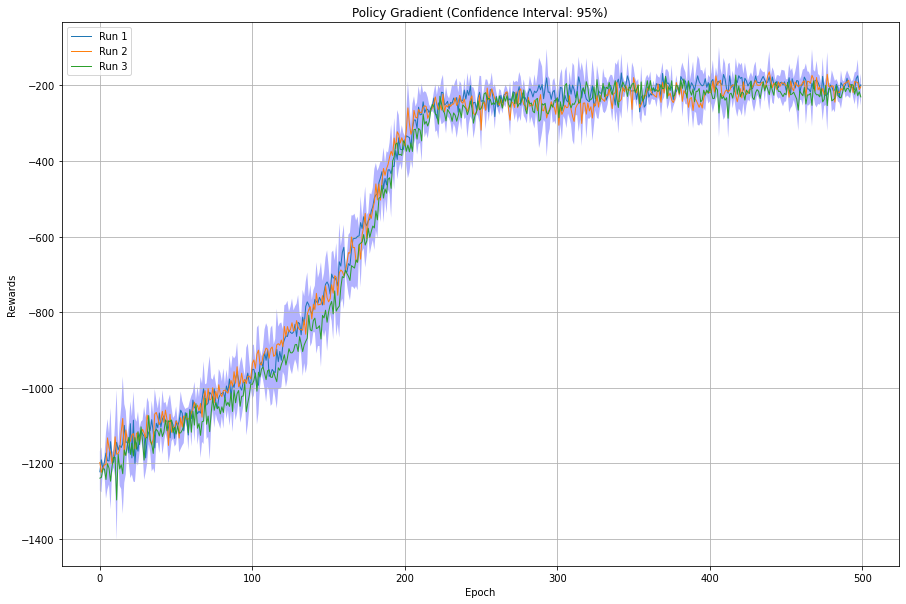

In [3]:
# collect saved results
import numpy as np
import scipy.stats as st
r1 = np.genfromtxt("InvertedPendulum_results.csv", delimiter=",")
all_results = [r1]
labels = ["REINFORCE"]

##############################################################
# Plot your Policy Gradient results below
##############################################################
import matplotlib.pyplot as plt
reward_arrays = [np.array(k) for k in r1]

# using list comprehension  
# to perform index list elements pairing
rew = [list(x) for x in zip(*reward_arrays)]

# Mean of the three trials
mean_rewards = np.mean(reward_arrays,axis=0)
conf_int = np.arange(len(mean_rewards)) 

mean_value = []
lower_value = []
upper_value = []

# Confidence Interval - v2
for k in range(len(mean_rewards)):
    mean_val, lower_val, upper_val = mean_confidence_interval(rew[k], confidence=0.95)
    mean_value.append(np.array(mean_val))
    lower_value.append(np.array(lower_val))
    upper_value.append(np.array(upper_val))
    


fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.plot(reward_arrays[0],linewidth=1)
ax.plot(reward_arrays[1],linewidth=1)
ax.plot(reward_arrays[2],linewidth=1)
# ax.plot(mean_value,linewidth=1.5,color='black')

ax.set(xlabel='Epoch', ylabel='Rewards', title='Policy Gradient (Confidence Interval: 95%)')
ax.legend(['Run 1','Run 2','Run 3'],loc='upper left')
ax.grid()

# https://matplotlib.org/stable/gallery/recipes/fill_between_alpha.html
ax.fill_between(conf_int, lower_value, upper_value, facecolor='blue', 
                alpha=0.3, label='1 sigma range')

fig.savefig("value_function.png")
plt.show()


